<a href="https://colab.research.google.com/github/morkev/statistical-computing/blob/main/N_Monopoly_Games.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Monopoly Simulation – CSIS 2430
#### By: Kevin Mora

The concept and exchange of money is not included in the simulation, and therefore there is no bank.

The final project will use the skills learned in CSIS-2430 to simulate thousands or millions of games of Monopoly. The main question we are trying to solve here is: which properties are landed on the most? What's the most popular kind of tile?

**There are two strategies**:
- Strategy A) If you have a Get Out of Jail Free, use it immediately.  If you don’t, you should immediately assume you would have paid the $50 fine and gotten out of jail immediately.

- Strategy B) If you have a Get Out of Jail Free card, use it immediately.  If you don’t, try to roll doubles for your next three turns to see if you can get out of jail that way.  If you have not gotten out of jail after three turns, assume you would have paid the $50 fine on the fourth term and get out of jail on that turn.

**NOTE**: there's no Bank and therefore we don't take money nor acquisition of properties as parameters.

In [ ]:
# First, let's import some useful libraries to make
# the calculations easier and create a visualization.
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
np.random.seed(1)

## Objects

Player and Board are the two separate classes.

**Class Player** has a couple features.<br>
1. One them is the "status" property, which locates the player on the board ∈ [0 .. 39]. It also has the "double counter," which as you already imagined, counts the number of consecutive doubles rolled.<br>
2. Another feature is the "possession" property, which has a free "Get Out of Jail" card from the Chance deck ∈ [0, 1] and another free "Get Out of Jail" card from the Community Chest deck ∈ [0, 1].

In [ ]:
class Player:
    def __init__(self):
        self.pos = 0    # location at given moment
        self.double = 0 # counter for doubles, because the player goes to jail for consecutive doubles
        self.imprisoned = False # imprisonment boolean variable that determines if player status('just visiting' V 'in jail')

        # player possession and record
        self.jailfree_chance = False
        self.jailfree_community = False
        self.tile_recorder = [0] * 40
        self.jail_recorder = [0] * 2 # two states; go to line 5

    # This function is responsible for rolling the dice
    def roll_dice(self):
        # Roll two fair six-sided dice
        dice = [np.random.randint(1,6+1) for _ in range(2)]
        # Check if it was a double; reset counter otherwise
        if dice[0] == dice[1]:
            self.double += 1
        else:
            self.reset_double()
        # Sum of dice values
        return sum(dice)

    # This function is responsible for updating and recording position
    def update_pos(self, new_pos):
        self.pos = new_pos
        self.tile_recorder[new_pos] += 1
        # Is the player imprisoned or visiting?
        if new_pos == 10:
                if self.imprisoned:
                    self.jail_recorder[1] += 1
                else:
                    self.jail_recorder[0] += 1

    # Reset the double counter
    def reset_double(self):
        self.double = 0

    # This function is responsible for updating the possession of jail free cards
    def update_jailfree(self, get_or_use, chance_or_community):
        if chance_or_community == 'Chance':
            if get_or_use == 'get':
                self.jailfree_chance = True
            else:
                self.jailfree_chance = False
        else:
            if get_or_use == 'get':
                self.jailfree_community = True
            else:
                self.jailfree_community = False

    # This function updates the imprisoned status
    def update_imprisoned(self, new_state):
        self.imprisoned = new_state

    # NOTE: do not clean player's record
    def new_game(self):
        self.pos = 0
        self.double = 0
        self.imprisoned = False
        self.jailfree_chance = False
        self.jailfree_community = False

**Class Board** has the following features:<br>
1) It can imitate a player's turn, including the roll of the dice and all the following events.<br>
2) It can simulate drawing a card from each deck.

**Source** of the names and properties of Class Board:<br>
Values fot the arrays "chance_deck" and "community_deck" were taken from the following site:
- https://www.monopolyland.com/list-monopoly-chance-community-chest-cards/

Squares and colors of the board (i.e., self.name and self.name_us) were taken from the following site:
- https://www.alamy.com/stock-photo-monopoly-26595286.html?imageid=36B82A12-64F3-4FA3-9D67-DE812B249BF9&p=4842&pn=1&searchId=d83a671e27f0f11519ed7c9456d909c1&searchtype=0

In [ ]:
class Board:
    def __init__(self):
        self.name = ['Go', 'Purple 1', 'Community Chest 1', 'Purple 2', 'Income Tax',
                     'Station 1', 'Sky 1', 'Chance 1', 'Sky 2', 'Sky 3',
                     'Jail', 'Pink 1', 'Utility 1', 'Pink 2', 'Pink 3',
                     'Station 2', 'Orange 1', 'Community Chest 2', 'Orange 2', 'Orange 3',
                     'Free Parking', 'Red 1', 'Chance 2', 'Red 2', 'Red 3',
                     'Station 3', 'Yellow 1', 'Yellow 2', 'Utility 2', 'Yellow 3',
                     'Go To Jail', 'Green 1', 'Green 2', 'Community Chest 3', 'Green 3',
                     'Station 4', 'Chance 3', 'Blue 1', 'Luxury Tax', 'Blue 2']

        self.name_us = ['Go', 'Mediterranean Avenue', 'Community Chest', 'Baltic Avenue', 'Income Tax',
                        'Reading Railroad', 'Oriental Avenue', 'Chance', 'Vermont Avenue', 'Connecticut Avenue',
                        'Jail', 'St. Charles Place', 'Electric Company', 'States Avenue', 'Virginia Avenue',
                        'Pennsylvania Railroad', 'St. James Place', 'Community Chest', 'Tennessee Avenue', 'New York Avenue',
                        'Free Parking', 'Kentucky Avenue', 'Chance', 'Indiana Avenue', 'Illinois Avenue',
                        'B. & O. Railroad', 'Atlantic Avenue', 'Ventnor Avenue', 'Water Works', 'Marvin Gardens',
                        'Go To Jail', 'Pacific Avenue', 'North Carolina Avenue', 'Community Chest', 'Pennsylvania Avenue',
                        'Short Line', 'Chance', 'Park Place', 'Luxury Tax', 'Board Walk']

        self.chance_deck = ['Advance to Boardwalk', 'Advance to Go', 'Advance to Illinois Avenue',
                            'Advance to St. Charles Place', 'Advance to the nearest Railroad', 'Advance to the nearest Railroad',
                            'Advance token to nearest Utility', 'Get out of Jail Free', 'Go back 3 spaces',
                            'Go to Jail', 'Make general repairs on all your property', 'Speeding fine',
                            'Take a trip to Reading Railroad', 'Elected Chairman of the Board',
                            'Loan matures'] # 16 cards

        self.community_deck = ['Advance to Go', 'Bank error', 'Doctors fees',
                               'Sale of stock', 'Get out of Jail Free', 'Go to Jail',
                               'Fund matures', 'Tax refund', 'Birthday', 'Insurance matures',
                               'Hospital fees', 'School fees', 'Receive consultancy fee',
                               'Street repairs', 'Beauty contest', 'Inherit']    # 16 cards

        # When init is true, then start shuffling
        np.random.shuffle(self.chance_deck)
        np.random.shuffle(self.community_deck)

    # In range [0 .. 39]. 40 tiles/slots.
    def bound(self, pos):
        return pos % 40

    # Simulate each turn
    def turn(self, player):
        roll_again = True

        while roll_again:
            roll_again = False

            # Use jail free cards if in jail
            # Sequence:
            # (Jail free from Chance -> Jail free from Community Chest -> Pay)
            if player.imprisoned:
                if player.jailfree_chance:
                    player.update_jailfree('use', 'Chance')
                    self.chance_deck.append('Get out of Jail Free')
                elif player.jailfree_community:
                    player.update_jailfree('use', 'Community')
                    self.community_deck.append('Get out of Jail Free')
                # Rolling a double to get out
                # Change boolean's value for Scenario A or B.
                player.update_imprisoned(False)
            # Roll the dice
            dice = player.roll_dice()

            # If the player rolled three doubles, go to Jail
            if player.double == 3:
                player.reset_double()
                player.update_imprisoned(True)
                new_pos = 10
            else:
                interim_pos = self.bound(player.pos + dice)
                # If Chance
                if interim_pos in [7,22,36]:
                    new_pos = self.chance(player, interim_pos)
                # If Community Chest
                elif interim_pos in [2,17,33]:
                    new_pos = self.community(player, interim_pos)
                # If stepped on go to Jail
                elif interim_pos == 30:
                    player.update_imprisoned(True)
                    new_pos = 10
                else:
                    new_pos = interim_pos

            # Record position and update
            player.update_pos(new_pos)

            # Roll again IFF it is a double AND the player is not imprisoned
            if player.double > 0 and not player.imprisoned:
                roll_again = True

    # Simulate drawing a Chance card
    def chance(self, player, interim_pos):
        # Draw the first card on the deck
        pick = self.chance_deck.pop(0)

        # As required in the assignment,
        # keep the card if it is jail-free;
        # put it at the bottom of the deck otherwise
        if pick == 'Get out of Jail Free':
            player.update_jailfree('get', 'Chance')
        else:
            self.chance_deck.append(pick)

        # As stated in the card, move to new position
        # Hard code instance of new position
        if pick == 'Advance to Go':
            return 0
        elif pick == 'Advance to Red 3':
            return 24
        elif pick == 'Advance to Pink 1':
            return 11
        elif pick == 'Advance to nearest utility':
            if interim_pos > 12 and interim_pos <= 28:
                return 28
            else:
                return 12
        elif pick == 'Advance to nearest station':
            if interim_pos > 5 and interim_pos <= 15:
                return 15
            elif interim_pos > 15 and interim_pos <= 25:
                return 25
            elif interim_pos > 25 and interim_pos <= 35:
                return 35
            else:
                return 5
        elif pick == 'Go back 3 spaces':
            return self.bound(interim_pos - 3)
        elif pick == 'Go to Jail':
            player.update_imprisoned(True)
            return 10
        elif pick == 'Advance to Station 1':
            return 5
        elif pick == 'Advance to Blue 2':
            return 39
        else:
            return interim_pos

    # Simulate drawing a Community Chest card
    def community(self, player, interim_pos):
        # Draw first card on the deck
        pick = self.community_deck.pop(0)

        # Keep the card if it is jail-free,
        # if not then put it at the bottom of the deck
        if pick == 'Get out of Jail Free':
            player.update_jailfree('get', 'Community')
        else:
            self.community_deck.append(pick)

        # 3. Move to new position as stated in the card
        if pick == 'Advance to Go':
            return 0
        elif pick == 'Go to Jail':
            player.update_imprisoned(True)
            return 10
        else:
            return interim_pos

## Simulation for Scenario B




$\text{Number of players}= N$<br>
$\text{Total number of rounds}= R \sim (30,3^2)$<br>
$\text{Number of opponent turns}= T(N) = (N-1)\ R$<br>

**NOTE**: Scenario B takes more time to compute (not including the additional time taken by the matplotlib library). And not to mention the fact that we are using Python.

In [ ]:
# 30 rounds
# Why? Depending on how many players you have, a Monopoly game typically lasts roughly 30 turns per player.
# As stated before, we can change these constants.
def get_n_round_stat(n_oppo):
    n_round_mean, n_round_std = 30, 3
    return n_round_mean, n_round_std

In [ ]:
opponents = []
# You can change the number of players
# This was updated in order to solve Question 4
n_oppo = 4-1 # e.g., a 4-player game has 3 opponents
# NOTE: value must not be equal or less than 0.

# Simulating 1,000 games takes ~1 second
# Simulating 10,000 games takes ~7 seconds
# Simulating 100,000 games takes ~90 seconds
# Simulating 1,000,000 games takes ~10 minutes
n_game = 1000
n_round_mean, n_round_std = get_n_round_stat(n_oppo)

# List of opponents initialization
for _ in range(n_oppo):
    opponents.append(Player())

# Simulate "n_game" games (1K .. 1M)
for i in range(round(n_game)):
    # New board :: clean the state of each player
    board = Board()
    for player in opponents:
        player.new_game()

    # Simulate a random number of rounds per game
    # We can brute force the value otherwise
    n_round = np.random.normal(n_round_mean, n_round_std)
    for j in range(round(n_round)):
        # Each turn for all
        for player in opponents:
            board.turn(player=player)

## Landing Probability for Scenario B

In [ ]:
# RGB values for the visualization
def get_colour(name):
    if 'Brown' in name:
        return '#8b4513'
    elif 'Sky' in name:
        return '#87ceeb'
    elif 'Pink' in name:
        return '#ca2c92'
    elif 'Orange' in name:
        return '#ffa500'
    elif 'Red' in name:
        return '#ff0000'
    elif 'Yellow' in name:
        return '#ffff00'
    elif 'Green' in name:
        return '#00ff00'
    elif 'Blue' in name:
        return '#0000ff'
    elif 'Station' in name:
        return '#d7baaa'
    elif 'Utility' in name:
        return '#bfdbae'
    elif 'Jail' in name:
        return '#696969'
    elif 'Chance' in name or 'Community Chest' in name:
        return '#ffc3c3'
    else:
        return '#f7ffb2'

In [ ]:
board = Board()
tile_name, tile_name_us = board.name, board.name_us

# Add tile counts of all players
tile_cnt = list(map(sum, zip(*[x.tile_recorder for x in opponents])))
jail_cnt = list(map(sum, zip(*[x.jail_recorder for x in opponents])))

tile_prob = [ x/sum(tile_cnt)*100 for x in tile_cnt ]
# Separate 'in jail' and 'just visiting'
tile_prob[10] = jail_cnt[1]/sum(tile_cnt)*100
tile_colour = [get_colour(name) for name in tile_name]

# Stack just visiting top bar
just_visiting = [0] * 40
just_visiting[10] = jail_cnt[0]/sum(tile_cnt)*100
just_visiting_colour = ['#5356f4'] * 40

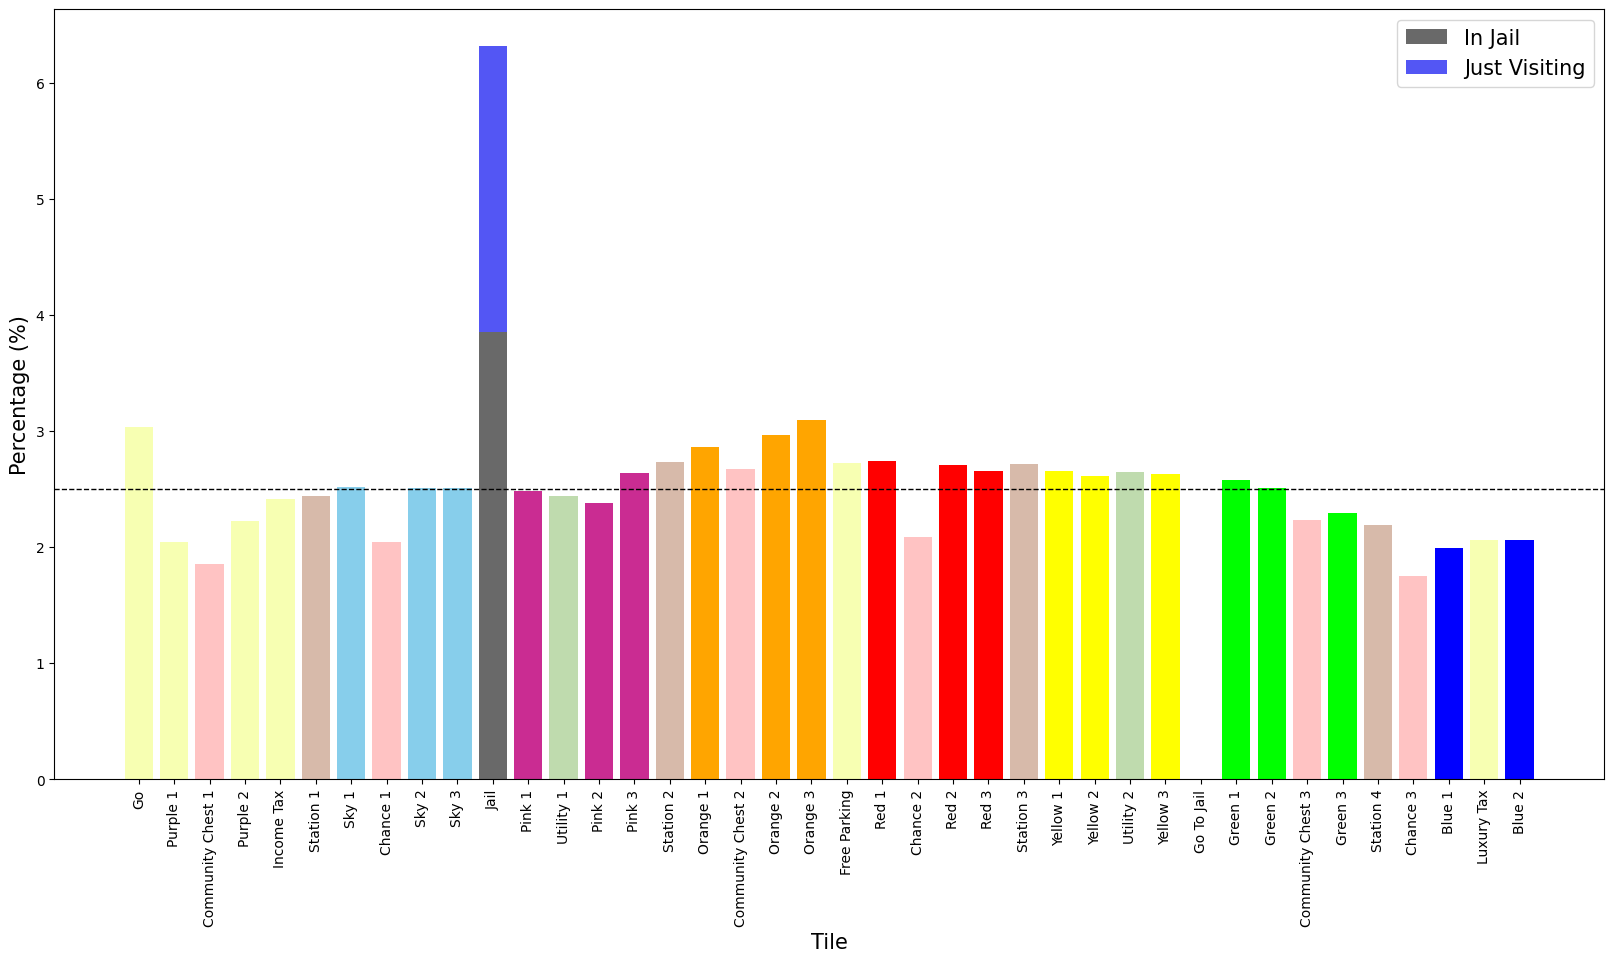

In [ ]:
plt.figure(figsize=(20,10))
bottom = plt.bar(tile_name, tile_prob, color=tile_colour)
top = plt.bar(tile_name, just_visiting, bottom=tile_prob, color=just_visiting_colour)

# 100% / 40 tiles = 2.5%/tile
plt.axhline(y=2.5,linewidth=1, color='k', linestyle='--')

plt.xticks(rotation='vertical')
plt.xlabel('Tile', fontsize=15)
plt.ylabel('Percentage (%)', fontsize=15)
plt.legend((bottom[10], top[10]), ('In Jail', 'Just Visiting'), prop={'size':15})

plt.savefig('landing_prob.png')
plt.show()

## Simulation for Scenario A

In [ ]:
"""
Simulate a single player moving around a monopoly board
to see the percentage of landing on each square.
"""
import argparse
import enum
import random

NUMBER_OF_SQUARES = 40

# Array to be updated each time an index is visited
count_visited = [
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0
]

# Array to be updated each time a SquareType is visited
count_type_visited = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


class SquareType(enum.Enum):
    """
    ENUM class representing the type
    of square on the Monopoly board.
    """
    GO = 0
    PURPLE = 1
    TAX = 2
    RAILROAD = 3
    LIGHT_BLUE = 4
    CHANCE = 5
    JAIL = 6
    PINK = 7
    UTILITY = 8
    ORANGE = 9
    COMMUNITY_CHEST = 10
    FREE_PARKING = 11
    RED = 12
    YELLOW = 13
    GO_TO_JAIL = 14
    GREEN = 15
    DARK_BLUE = 16

# Each square is defined by a dictionary with name and type.
squares = [
    {"name": "Go", "type": SquareType.GO},
    {"name": "Mediterranean Avenue", "type": SquareType.PURPLE},
    {"name": "Community Chest", "type": SquareType.COMMUNITY_CHEST},
    {"name": "Baltic Avenue", "type": SquareType.PURPLE},
    {"name": "Income Tax", "type": SquareType.TAX},
    {"name": "Reading Railroad", "type": SquareType.RAILROAD},
    {"name": "Central Avenue", "type": SquareType.LIGHT_BLUE},
    {"name": "Chance", "type": SquareType.CHANCE},
    {"name": "Vermont Avenue", "type": SquareType.LIGHT_BLUE},
    {"name": "Connecticut Avenue", "type": SquareType.LIGHT_BLUE},
    {"name": "Jail", "type": SquareType.JAIL},
    {"name": "St. Charles Place", "type": SquareType.PINK},
    {"name": "Electric Company", "type": SquareType.UTILITY},
    {"name": "States Avenue", "type": SquareType.PINK},
    {"name": "Virginia Avenue", "type": SquareType.PINK},
    {"name": "Pennsylvania Railroad", "type": SquareType.RAILROAD},
    {"name": "St. James Place", "type": SquareType.ORANGE},
    {"name": "Community Chest", "type": SquareType.COMMUNITY_CHEST},
    {"name": "Tennessee Avenue", "type": SquareType.ORANGE},
    {"name": "New York Avenue", "type": SquareType.ORANGE},
    {"name": "Free Parking", "type": SquareType.FREE_PARKING},
    {"name": "Kentucky Avenue", "type": SquareType.RED},
    {"name": "Chance", "type": SquareType.CHANCE},
    {"name": "Indiana Avenue", "type": SquareType.RED},
    {"name": "Illinois Avenue", "type": SquareType.RED},
    {"name": "B. & O. Railroad", "type": SquareType.RAILROAD},
    {"name": "Atlantic Avenue", "type": SquareType.YELLOW},
    {"name": "Ventnor Avenue", "type": SquareType.YELLOW},
    {"name": "Water Works", "type": SquareType.UTILITY},
    {"name": "Marvin Gardens", "type": SquareType.YELLOW},
    {"name": "Go To Jail", "type": SquareType.GO_TO_JAIL},
    {"name": "Pacific Avenue", "type": SquareType.GREEN},
    {"name": "North Carolina Avenue", "type": SquareType.GREEN},
    {"name": "Community Chest", "type": SquareType.COMMUNITY_CHEST},
    {"name": "Pennsylvania Avenue", "type": SquareType.GREEN},
    {"name": "Short Line", "type": SquareType.RAILROAD},
    {"name": "Chance", "type": SquareType.CHANCE},
    {"name": "Park Place", "type": SquareType.DARK_BLUE},
    {"name": "Luxury Tax", "type": SquareType.DARK_BLUE},
    {"name": "Board Walk", "type": SquareType.DARK_BLUE}
]

SQUARE_INDEX_GO = 0
SQUARE_INDEX_READING_RR = 5
SQUARE_INDEX_CHANGE_1 = 7
SQUARE_INDEX_JAIL = 10
SQUARE_INDEX_ST_CHARLES = 11
SQUARE_INDEX_ELECTRIC_CO = 12
SQUARE_INDEX_PENN_RR = 15
SQUARE_INDEX_CHANCE_2 = 22
SQUARE_INDEX_ILLINOIS = 24
SQUARE_INDEX_BO_RR = 25
SQUARE_INDEX_WATER_WORKS = 28
SQUARE_INDEX_SHORT_LINE_RR = 35
SQUARE_INDEX_CHANCE_3 = 36
SQUARE_INDEX_BOARDWALK = 39

cc_cards = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
CC_CARD_NUMBER_ADVANCE_TO_GO = 1
CC_CARD_NUMBER_GET_OUT_OF_JAIL_FREE = 2
CC_CARD_NUMBER_GO_TO_JAIL = 3


chance_cards = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
C_CARD_NUMBER_ADVANCE_TO_GO = 1
C_CARD_NUMBER_ADVANCE_TO_ILLINOIS = 2
C_CARD_NUMBER_ADVANCE_TO_ST_CHARLES = 3
C_CARD_NUMBER_ADVANCE_TO_NEAREST_UTILITY = 4
C_CARD_NUMBER_ADVANCE_TO_NEAREST_RAILROAD = 5
C_CARD_NUMBER_GET_OUT_OF_JAIL_FREE = 6
C_CARD_NUMBER_GO_BACK_3 = 7
C_CARD_NUMBER_GO_TO_JAIL = 8
C_CARD_NUMBER_GO_TO_READING = 9
C_CARD_NUMBER_GO_TO_BOARDWALK = 10


class Player:
    """
    Player class holding information about the
    Player's movements and dice rolls on the board.
    """
    def __init__(self):
        self.index_position = 0
        self.in_jail = False
        self.has_get_out_of_jail_free_card = False
        self.number_of_jail_attempts = 0
        self.number_of_doubles_rolled = 0
        self.number_of_rounds = 0

    def simulate_round(self):
        dice_value, is_double = self.roll()
        if self.in_jail:
            if is_double or self.number_of_jail_attempts == 3:
                self.number_of_jail_attempts = 0
                self.move(dice_value, is_double)
                self.evaluate_position()
            elif self.number_of_jail_attempts == 3:
                self.number_of_jail_attempts += 1
        else:
            self.move(dice_value, is_double)
            self.evaluate_position()

    @staticmethod
    def roll():
        dice_1 = random.randint(1, 6)
        dice_2 = random.randint(1, 6)
        is_double = dice_1 == dice_2
        return dice_1 + dice_2, is_double

    def move(self, number_of_spaces, is_double):
        # 3 consecutive doubles will put you in jail
        if is_double:
            self.number_of_doubles_rolled += 1
        else:
            self.number_of_doubles_rolled = 0
        # Move to appropriate spot on board
        if self.number_of_doubles_rolled == 3:
            self.move_to_jail()
        else:
            new_position = self.index_position + number_of_spaces
            self.index_position = new_position % NUMBER_OF_SQUARES

    def move_to_go(self):
        self.index_position = SQUARE_INDEX_GO

    def move_to_jail(self):
        self.index_position = SQUARE_INDEX_JAIL
        self.in_jail = True
        self.number_of_doubles_rolled = 0

    def move_to_illinois(self):
        self.index_position = SQUARE_INDEX_ILLINOIS

    def move_to_st_charles(self):
        self.index_position = SQUARE_INDEX_ST_CHARLES

    def move_to_nearest_utility(self):
        position = self.index_position
        if (position == SQUARE_INDEX_CHANGE_1
                or position == SQUARE_INDEX_CHANCE_2):
            self.index_position = SQUARE_INDEX_ELECTRIC_CO
        else:
            self.index_position = SQUARE_INDEX_WATER_WORKS

    def move_to_nearest_railroad(self):
        position = self.index_position
        if position == SQUARE_INDEX_CHANGE_1:
            self.index_position = SQUARE_INDEX_PENN_RR
        elif position == SQUARE_INDEX_CHANCE_2:
            self.index_position = SQUARE_INDEX_BO_RR
        else:
            self.index_position = SQUARE_INDEX_READING_RR

    def move_to_reading(self):
        self.index_position = SQUARE_INDEX_READING_RR

    def move_to_boardwalk(self):
        self.index_position = SQUARE_INDEX_BOARDWALK

    def evaluate_position(self):
        global cc_cards, chance_cards, count_visited
        # Increment square visited
        count_visited[self.index_position] += 1
        # Evaluate what to do at new position
        position_type = squares[self.index_position]["type"]
        count_type_visited[position_type.value] += 1
        if position_type == SquareType.GO_TO_JAIL:
            self.move_to_jail()
        elif position_type == SquareType.COMMUNITY_CHEST:
            if len(cc_cards) == 0:
                shuffle_community_chest_deck()
            card = cc_cards.pop()
            if card == CC_CARD_NUMBER_ADVANCE_TO_GO:
                self.move_to_go()
            elif card == CC_CARD_NUMBER_GET_OUT_OF_JAIL_FREE:
                self.has_get_out_of_jail_free_card = True
            elif card == CC_CARD_NUMBER_GO_TO_JAIL:
                self.move_to_jail()
        elif position_type == SquareType.CHANCE:
            if len(chance_cards) == 0:
                shuffle_chance_deck()
            card = chance_cards.pop()
            moved = False  # Flag to see if the Player moved
            if card == C_CARD_NUMBER_ADVANCE_TO_GO:
                moved = True
                self.move_to_go()
            elif card == C_CARD_NUMBER_ADVANCE_TO_ILLINOIS:
                moved = True
                self.move_to_illinois()
            elif card == C_CARD_NUMBER_ADVANCE_TO_ST_CHARLES:
                moved = True
                self.move_to_st_charles()
            elif card == C_CARD_NUMBER_ADVANCE_TO_NEAREST_UTILITY:
                moved = True
                self.move_to_nearest_utility()
            elif card == C_CARD_NUMBER_ADVANCE_TO_NEAREST_RAILROAD:
                moved = True
                self.move_to_nearest_railroad()
            elif card == C_CARD_NUMBER_GET_OUT_OF_JAIL_FREE:
                self.has_get_out_of_jail_free_card = True
            elif card == C_CARD_NUMBER_GO_BACK_3:
                moved = True
                new_position = self.index_position - 3
                self.index_position = new_position % NUMBER_OF_SQUARES
            elif card == C_CARD_NUMBER_GO_TO_JAIL:
                moved = True
                self.move_to_jail()
            elif card == C_CARD_NUMBER_GO_TO_READING:
                moved = True
                self.move_to_reading()
            elif card == C_CARD_NUMBER_GO_TO_BOARDWALK:
                moved = True
                self.move_to_boardwalk()
            # Reevaluate position if a card moved Player
            if moved:
                self.evaluate_position()


def calculate_percentage_visited():
    """
    Calculate the percentage of visiting each square based on the number of
    rounds simulated. Finally, a list of percentages for squares and types
    will be returned.
    """
    global count_visited
    percentages_squares = []
    percentages_types = []
    for num_visited in count_visited:
        percentage = round((num_visited / sum(count_visited)) * 100, 3)
        percentage_str = str(percentage) + "%"
        percentages_squares.append(percentage_str)
    for num_visited in count_type_visited:
        percentage = round((num_visited / sum(count_type_visited)) * 100, 3)
        percentage_str = str(percentage) + "%"
        percentages_types.append(percentage_str)
    return percentages_squares, percentages_types


def simulate(number_of_rounds, number_of_iterations):
    """
    Simulate a player moving around a Monopoly board.
    """
    global count_visited
    for ii in range(number_of_iterations):
        if ii % 100000 == 0:
            print("Iteration {} completed".format(ii))
        player = Player()
        for jj in range(number_of_rounds):
            player.simulate_round()
    percentages_squares, percentages_types = calculate_percentage_visited()
    for ii in range(len(squares)):
        square = squares[ii]
        percentage = percentages_squares[ii]
        print(square["name"] + ": " + percentage)
    print()
    for ii in range(len(count_type_visited)):
        type_name = SquareType(ii).name
        percentage = percentages_types[ii]
        print(type_name + ": " + percentage)


def shuffle_community_chest_deck():
    """
    Shuffles a new community chest deck.
    """
    global cc_cards
    cc_cards.clear()
    cc_cards.extend([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])
    random.shuffle(cc_cards)


def shuffle_chance_deck():
    """
    Shuffles a new chance deck.
    """
    global chance_cards
    chance_cards.clear()
    chance_cards.extend([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])
    random.shuffle(chance_cards)


def init():
    """
    Initializes a new game. Community Chest and Chance decks are shuffled.
    """
    shuffle_community_chest_deck()
    shuffle_chance_deck()


if __name__ == "__main__":
    # Simulate the Monopoly games
    init()
    simulate(30, 1000)


Iteration 0 completed
Go: 2.121%
Mediterranean Avenue: 1.588%
Community Chest: 2.007%
Baltic Avenue: 1.917%
Income Tax: 2.207%
Reading Railroad: 2.953%
Central Avenue: 2.359%
Chance: 2.549%
Vermont Avenue: 2.521%
Connecticut Avenue: 2.549%
Jail: 5.422%
St. Charles Place: 2.901%
Electric Company: 3.391%
States Avenue: 2.102%
Virginia Avenue: 3.01%
Pennsylvania Railroad: 2.483%
St. James Place: 3.281%
Community Chest: 2.297%
Tennessee Avenue: 3.339%
New York Avenue: 2.582%
Free Parking: 3.415%
Kentucky Avenue: 2.192%
Chance: 3.519%
Indiana Avenue: 2.249%
Illinois Avenue: 3.215%
B. & O. Railroad: 2.345%
Atlantic Avenue: 2.563%
Ventnor Avenue: 2.302%
Water Works: 2.582%
Marvin Gardens: 2.055%
Go To Jail: 2.24%
Pacific Avenue: 2.178%
North Carolina Avenue: 2.211%
Community Chest: 2.164%
Pennsylvania Avenue: 1.926%
Short Line: 1.888%
Chance: 1.726%
Park Place: 1.788%
Luxury Tax: 1.793%
Board Walk: 2.069%

GO: 2.121%
PURPLE: 3.505%
TAX: 2.207%
RAILROAD: 9.669%
LIGHT_BLUE: 7.429%
CHANCE: 7.795